___
# __Deep Neural Network from scratch__
### _Author: Aki Taniguchi_
### _Original date: 09/01/2020_
### _Last update: 25/01/2020_
___

## __I. Setting up the environment__
___
### _I.A. Loading libraries_
First of all, we start by importing relevant libraries needed for the entire code.  
We will also set up our hypothetical hyper-parameters to double check at each step whether the function is working as intended.

In [1]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
# Note that keras is only used to load the base dataset called MNIST

Using TensorFlow backend.


### _I.B. Data processing_
We will now load and process the MNIST data contained in keras datasets to have a concrete example on which we can test our neural network.

In [2]:
# Load the base dataset using Keras MNIST Dataset, on which we only take 0 and 1 class as output values
(x_train, y_train), (x_test, y_test) = mnist.load_data()

class_0 = (y_train == 2)
class_0 = class_0.tolist()
class_0 = [i for i, x in enumerate(class_0) if x]
class_1 = (y_train == 3)
class_1 = class_1.tolist()
class_1 = [i for i, x in enumerate(class_1) if x]

index_key = class_0 + class_1

X = x_train[index_key]
Y = y_train[index_key]

del (x_train, x_test, y_train, y_test)

# We now have a binary outcome, between class_0 and class_1. Let's shuffle it a little so that the exercise is more interesting
assert len(X) == len(Y)
index_key = list(np.random.permutation(range(len(X))))
X = X[index_key]
Y = Y[index_key]


# Data Processing

# X has a shape of (m, n_x), m observations and n_x features
# We transform the 28x28 pixel matrix into a 28^2 vector
m = X.shape[0]
n_x = np.power(X.shape[1], 2)
X = X.reshape(m, n_x)

# We also explicitly need to set Y column to be 1 ("?" by default in MNIST dataset)
Y = Y.reshape(Y.shape[0], 1)

# Given the outcome is a categorical, we need a one-hot encoding of Y
Y = np.where(Y == 2, 0, 1)

# Normalize X for quicker training
X.astype("float64")
X = X/255

# Now initializing the A matrix, used in the Deep Neural Network
A = {}
A["0"] = X

# Making sure that we have same number of observations for X (or A0) and Y
assert Y.shape[0] == A["0"].shape[0]

# Show number of features and observations
print("Number of observations: {0}, Number of features: {1}".format(X.shape[0], X.shape[1]))
print("Number of outcome: {0}".format(Y.shape[0]))
print("X shape:", X.shape)
print("Y shape:", Y.shape)

Number of observations: 12089, Number of features: 784
Number of outcome: 12089
X shape: (12089, 784)
Y shape: (12089, 1)


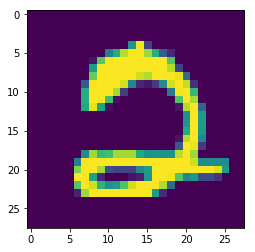

In [3]:
# Let us see what the pictures look like. The index can be changed up to m
ind = 10000
plt.imshow(A["0"][ind].reshape(28,28))

### _I.C. Default Hyperparameter tuning_
Now that we have our dataset, we will set up the default Hyperparameter to use in order to test our algorithm.

In [4]:
# Setting up the hyper-parameters of the Deep Neural Network

# Number of Layer and Number of Neuron in each layer
# Input layer not included, last number should be number of Neuron for the output layer
nb_layer = 3
neuron_quantity = [4, 3, 1]
assert len(neuron_quantity) == nb_layer

# Define Activation function (needs to be same length as neuron Quantity)
activations = ["none", "relu", "relu", "sigmoid"]
assert len(activations) == nb_layer + 1

## II. Initialize parameters
___
We need to initialize the model parameters by assigning the following:
- for the weights (W), random numbers which have (n_l-1, n_l) dimension. They can't be assigned 0 due to Neural Network being unable to "break symmetry". However, we want them to be close to 0, so that the gradient descent works more efficiently (steeper curve around 0 for each activation function). 
- for biases (b), zero values which have (1, n_l) dimension.


Note that the weight initialization follows the "He et al." rule, e.g.:
$$W^{[l]} = \mathcal{N}(0, 1) * \sqrt{\frac{2}{n^{[l-1]}}}$$
With:
$$dimW^{[l]} = (n^{[l-1]}, n^{[l]})$$

In [5]:
def initialize_parameters(nb_layer, neuron_quantity, A):

    W = {}; b = {}; nb_neuron = {}
    L = nb_layer

    # Define number of Neuron, based on input so that we can set up the dimension of each parameter
    # The first dimension of the number of Neuron is the number of features (X), which corresponds to A["0"].
    nb_neuron["0"] = A["0"].shape[1]
    for l in range(1, nb_layer+1):
        nb_neuron[str(l)] = neuron_quantity[l-1]

    # Initializing parameters as defined above
    for l in range(1, L+1):
        W[str(l)] = np.random.randn(nb_neuron[str(l-1)], nb_neuron[str(l)]) * np.sqrt(2/nb_neuron[str(l-1)])
        b[str(l)] = np.zeros((1, nb_neuron[str(l)]))

    return W, b

In [6]:
# Double check if the function works well (both value and dimension) (W, b)
W, b = initialize_parameters(nb_layer, neuron_quantity, A)

print("W", W)
print("b", b)
for i in range(1, nb_layer+1):
    print("W[", str(i),"] shape:", W[str(i)].shape)
    print("b[", str(i),"] shape:", b[str(i)].shape)

W {'1': array([[-0.04913076,  0.08143311, -0.00656477,  0.01813978],
       [-0.04815778,  0.0491001 , -0.03775359,  0.04103352],
       [-0.0516538 , -0.0158238 ,  0.03665995,  0.01286588],
       ...,
       [ 0.06192295,  0.05572182, -0.01645127,  0.09499402],
       [ 0.09626794,  0.05208633, -0.06349296, -0.00066804],
       [-0.09731242, -0.07513784,  0.00347835,  0.0157113 ]]), '2': array([[ 1.04242348,  0.98795913, -0.00451982],
       [ 0.2247792 , -0.63279144, -0.51482374],
       [-0.9221519 , -0.59790809, -0.50878195],
       [-0.32782927,  0.86880052,  0.02117861]]), '3': array([[-0.06018532],
       [-0.09156316],
       [ 0.0364824 ]])}
b {'1': array([[0., 0., 0., 0.]]), '2': array([[0., 0., 0.]]), '3': array([[0.]])}
W[ 1 ] shape: (784, 4)
b[ 1 ] shape: (1, 4)
W[ 2 ] shape: (4, 3)
b[ 2 ] shape: (1, 3)
W[ 3 ] shape: (3, 1)
b[ 3 ] shape: (1, 1)


## III. Forward propagation
___
We first need to define how to compute the activation function.  
Once the activation function is defined, we are ready to compute the linear function Z and its respective activated output A.  
Reminder of the formulas:
$$Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]} \tag{1} $$  
Technically $Z^{[l]} = A^{[l-1]} W^{[l]} + b^{[l]}$ if observations are in rows, which is the case in this paper.  

And each activation function as follows:  
$$Linear = Z^{[l]}$$
$$ReLU = max(0, Z^{[l]})$$
$$LeakyReLU = max(0.01*Z^{[l]}, Z^{[l]})$$
$$Sigmoid = \frac{1}{1 + e^{-Z^{[l]}}}$$
$$Tanh = \frac{e^{Z^{[l]}} - e^{-Z^{[l]}}}{e^{Z^{[l]}} + e^{-Z^{[l]}}} \tag{2} $$
Therefore, g(Z) is the forward propagation and returns $x^{[l]}_{i} = y^{[l-1]}_{i}$ which will be used in the following layer.  
Note the dimension of both Z and A needs to be (m, n_l).

In [7]:
# Defining the helper function to compute the activation (fx(Z))
# We only treat Linear / ReLU / LeakyReLU / Tanh / Sigmoid funcions
def activation_function(activation_name, Z):
    if activation_name == "linear":
        fx = Z
    elif activation_name == "relu":
        fx = np.maximum(0, Z)
    elif activation_name == "leakyRelu":
        fx = np.maximum(Z*0.01, Z)
    elif activation_name == "tanh":
        fx = (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
    elif activation_name == "sigmoid":
        fx = 1 / (1 + np.exp(-Z))
    else:
        fx = "No function associated with: " + activation_name + "!"

    return fx      

In [8]:
# Calculate the forward propagation for each layer (Z, A)
# A is the feature/result matrix
# Note that both A and Z will be used in the backward propagation computation, hence the need to store them into variables
def forward_propagation(nb_layer, W, b, A, fx):
    
    L = nb_layer; Z = {}

    for l in range(1, L+1):
        Z[str(l)] = np.dot(A[str(l-1)], W[str(l)]) + b[str(l)]
        A[str(l)] = activation_function(fx[l], Z[str(l)])
    
    return A, Z

In [9]:
# Check if Activation function is working correctly
nb_check = -1
for i in range(0, nb_layer+1):
    check = activation_function(activations[i], nb_check)
    print(i, ": ", check)

# Check if forward propagtion is working correctly (need to run previous check cell)
A, Z = forward_propagation(nb_layer, W, b, A, activations)

print("A", A)
print("Z", Z)
for i in range(1, nb_layer+1):
    print("A[", str(i),"] shape:", A[str(i)].shape)
    print("Z[", str(i),"] shape:", Z[str(i)].shape)

0 :  No function associated with: none!
1 :  0
2 :  0
3 :  0.2689414213699951
A {'0': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), '1': array([[0.        , 0.03708231, 0.        , 0.61187328],
       [0.        , 0.4234924 , 0.        , 0.30499353],
       [0.        , 0.35986782, 0.        , 0.75400464],
       ...,
       [0.        , 0.1786732 , 0.        , 0.41050465],
       [0.        , 0.54061277, 0.        , 0.52522065],
       [0.        , 0.1568998 , 0.        , 0.70361397]]), '2': array([[0.        , 0.50813046, 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.42735835, 0.        ],
       ...,
       [0.        , 0.24358378, 0.        ],
       [0.        , 0.11421684, 0.        ],
       [0.        , 0.51201534, 0.        ]]), '3': array([[0.4883705

## IV. Calculate Cost
___
In this piece of code, we are creating an image recognition engine. Therefore, we use a logistic regression based neural network output, which means the cost function is the maximum likelihood estimation.  

For m observations, we have:
$$Cost = -\frac{1}{m} \sum \limits_{i=1}^{m} {(y_{i} \log \left(a^{[L]}_{i} \right) + (1-y_{i}) \log \left(1-a^{[L]}_{i} \right)) } \tag{3} $$

In [10]:
# Compute Cost (Average of Loss)
def compute_cost(AL, Y):

    m = Y.shape[0]
    e = 1e-10
    cost = -(1/m) * np.sum((Y * np.log(AL+e)) + (1-Y) * np.log(1-AL+e))
    
    return cost

In [11]:
# Check if the cost function works
cost = compute_cost(A[str(nb_layer)], Y)
print(cost)

0.6915684363320475


## V. Backward Propagation
___
Now that we have the output as well as the cost function computed thanks to the forward propagation, we need to go backward to update the parameters.  

The best set of parameters which minimizes the cost function are the set of points where the first derivative is equal to 0. Thankfully, the cost function is convex, therefore the local minimum is a global minimum.  

However, the best set cannot be found as there is no closed-form equation to solve. The most efficient way is to use gradient descent, which is a method to find the minimum point iteratively, by substracting its slope (at the point of the moment). Effectively, if the slope is positive, this mean the minimum is "on the left", and the new parameter is small (x - s < x, with s > 0). Conversely, if we find out the slope is negative, the minimum is "on the right", so we get a bigger new parameter (x - s > x, given s < 0). Thus, substracting the slope at a given rate pushes to the right direction in finding the local minimum.  

We therefore understand that we need to compute the slope e.g. derivative on each point. To get the parameter derivative (dW, db), we will proceed using the chain rule (derivee de fonction composee). Let us start with dA and dZ, the derivative of the forward propagtion. Formulas are given as (in the order of backwardation):
$$dA^{[L]} = \frac{\partial Cost}{\partial A^{[L]}} = \frac{-Y}{A^{[L]}} + \frac{(1-Y)}{(1-A^{[L]})} \tag{4}$$
$$dZ^{[L]} = \frac{\partial Cost}{\partial A^{[L]}} \frac{\partial A^{[L]}}{\partial Z^{[L]}} = dA^{[L]} * g'(Z^{[L]}) \tag{5}$$
Now remind that, as per equation (1):
$$Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$$
It follows that:
$$dA^{[L-1]} = \frac{\partial Cost}{\partial A^{[L]}} \frac{\partial A^{[L]}}{\partial Z^{[L]}} \frac{\partial Z^{[L]}}{\partial A^{[L-1]}} = dZ^{[L]}W'^{[L]}$$
Which can be generalized as:
$$dA^{[l-1]} = dZ^{[l]}W'^{[l]} \tag{6}$$
And finally:
$$dZ^{[L-1]} = \frac{\partial Cost}{\partial A^{[L]}} \frac{\partial A^{[L]}}{\partial Z^{[L]}} \frac{\partial Z^{[L]}}{\partial A^{[L-1]}} \frac{\partial A^{[L-1]}}{\partial Z^{[L-1]}} = dZ^{[l]}W'^{[l]} * g'(Z^{[L-1]})$$
Or more generally:
$$dZ^{[l-1]} = dZ^{[l]}W'^{[l]} * g'(Z^{[l-1]}) \tag{7}$$
In order to compute the backward propagation, we will therefore only use (4), (5) and (7).

In [12]:
# Defining the helper function to compute the backward-activation (dfx/dZ)
# We only treat Linear / ReLU / LeakyReLU / Tanh / Sigmoid funcions
def backward_activation_function(activation_name, Z):
    if activation_name == "linear":
        dF = 1
    elif activation_name == "relu":
        dF = np.where(Z < 0, 0, 1)
    elif activation_name == "leakyRelu":
        dF = np.where(Z < 0, 0.01, 1)
    elif activation_name == "tanh":
        dF = 1 - np.power(activation_function(activation_name, Z), 2)
    elif activation_name == "sigmoid":
        dF = activation_function(activation_name, Z) * (1 - activation_function(activation_name, Z))
    else:
        dF = "No function associated with: " + activation_name + "!"

    return dF     

In [13]:
# Get the backward propagtion (dZ)
def backward_propagation(nb_layer, Y, A, Z, W, activations):
    
    L = nb_layer; dZ = {}

    # We need to compute the derivative of the last layer separately, as it is a non-generic formula
    dAL = -(Y/A[str(L)]) + (1-Y)/(1-A[str(L)])
    dZ[str(L)] = dAL * backward_activation_function(activations[L], Z[str(L)])

    # We can now compute the generalized backward propagation
    for l in range(L-1, 0, -1):
        dZ[str(l)] = np.dot(dZ[str(l+1)], W[str(l+1)].T) * backward_activation_function(activations[l], Z[str(l)])

    return dZ

In [14]:
# Check if Backward Activation function is working correctly
nb_check = -1
for i in range(0, nb_layer+1):
    check = backward_activation_function(activations[i], nb_check)
    print(i, ": ", check)

# Check if forward propagtion is working correctly (need to run previous check cells)
dZ = backward_propagation(nb_layer, Y, A, Z, W, activations)
print("dZ", dZ)
for i in range(1, nb_layer+1):
    print("dZ[", str(i),"] shape:", dZ[str(i)].shape)

0 :  No function associated with: none!
1 :  0
2 :  0
3 :  0.19661193324148185
dZ {'3': array([[ 0.48837059],
       [ 0.5       ],
       [-0.50978132],
       ...,
       [-0.50557559],
       [-0.50261449],
       [ 0.48828171]]), '2': array([[-0.        , -0.04471675,  0.        ],
       [-0.        , -0.        ,  0.        ],
       [ 0.        ,  0.04667719, -0.        ],
       ...,
       [ 0.        ,  0.0462921 , -0.        ],
       [ 0.        ,  0.04602097, -0.        ],
       [-0.        , -0.04470861,  0.        ]]), '1': array([[-0.        ,  0.02829638,  0.        , -0.03884994],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.02953692, -0.        ,  0.04055316],
       ...,
       [ 0.        , -0.02929324, -0.        ,  0.0402186 ],
       [ 0.        , -0.02912168, -0.        ,  0.03998304],
       [-0.        ,  0.02829123,  0.        , -0.03884287]])}
dZ[ 1 ] shape: (12089, 4)
dZ[ 2 ] shape: (12089, 3)
dZ[ 3 ] shape: (12089,

## VI. Calculate Gradient
___
We have the back propagation implemented, we now need to calculate the gradient for each parameter W and b. From (1), (5) and (7) we have:
$$dZ^{[L]} = \frac{\partial Cost}{\partial A^{[L]}} \frac{\partial A^{[L]}}{\partial Z^{[L]}} = dA^{[L]} * g'(Z^{[L]})$$
$$dZ^{[l-1]} = dZ^{[l]}W'^{[l]} * g'(Z^{[l-1]})$$
$$Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$$
It follows that:
$$dW^{[L]} = \frac{\partial Cost}{\partial A^{[L]}} \frac{\partial A^{[L]}}{\partial Z^{[L]}} \frac{\partial Z^{[L]}}{\partial W^{[L]}}= dZ^{[L]} * A'^{[L-1]}$$  
Note that here again, we have $dW^{[L]} = A'^{[L-1]} dZ^{[L]} $ for observations set in rows.  

$$db^{[L]} = \frac{\partial Cost}{\partial A^{[L]}} \frac{\partial A^{[L]}}{\partial Z^{[L]}} \frac{\partial Z^{[L]}}{\partial b^{[L]}}= dZ^{[L]}$$
For m observations, the gradient of one layer is simply the average of the gradient of that layer for all observations:
$$dW^{[l]} = \frac{1}{m} dZ^{[l]} * A'^{[l-1]} \tag{8}$$
$$db^{[l]} = \frac{1}{m} \sum \limits_{i=1}^{m} {dZ^{[l]}} \tag{9}$$

In [15]:
# Get the gradients for all layers (dW, db)
def calculate_gradient(nb_layer, dZ, A):

    m = A["0"].shape[0]
    L = nb_layer; dW = {}; db = {}

    for l in range(L, 0, -1):
        dW[str(l)] = 1/m * np.dot(A[str(l-1)].T, dZ[str(l)])
        db[str(l)] = 1/m * np.sum(dZ[str(l)], axis=0, keepdims=True)

    return dW, db

In [16]:
# Check if gradient is calculated correctly
dW, db = calculate_gradient(nb_layer, dZ, A)
print("dW", dW)
print("db", db)
for i in range(1, nb_layer+1):
    print("dW[", str(i),"] shape:", dW[str(i)].shape)
    print("db[", str(i),"] shape:", db[str(i)].shape)

dW {'3': array([[-0.00239849],
       [ 0.01745007],
       [ 0.00063251]]), '2': array([[8.54717162e-05, 1.50870806e-04, 2.44507446e-06],
       [1.64944199e-03, 4.49890606e-03, 2.19845821e-06],
       [1.22036033e-05, 4.28636974e-05, 7.78207046e-08],
       [9.28076823e-04, 1.29564896e-03, 1.14538975e-03]]), '1': array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])}
db {'3': array([[-0.01351183]]), '2': array([[ 0.00141477, -0.0019872 ,  0.00241786]]), '1': array([[ 0.00164505, -0.00212567, -0.00037131, -0.00177623]])}
dW[ 1 ] shape: (784, 4)
db[ 1 ] shape: (1, 4)
dW[ 2 ] shape: (4, 3)
db[ 2 ] shape: (1, 3)
dW[ 3 ] shape: (3, 1)
db[ 3 ] shape: (1, 1)


## VII. Update parameters
___
Thanks to the backward propagation, we now have been able to calculate the gradients. The only thing left is to update the parameters to approach the local minimum. The update is given as follows:
$$W^{[l]} = W^{[l]} - \alpha . dW^{[l]} \tag{10}$$
$$b^{[l]} = b^{[l]} - \alpha . db^{[l]} \tag{11}$$

In [17]:
# Get the updated parameters (W, b)
def update_parameters(nb_layer, W, b, dW, db, learning_rate):

    L = nb_layer

    for l in range(1, L+1):
        W[str(l)] = W[str(l)] - learning_rate * dW[str(l)]
        b[str(l)] = b[str(l)] - learning_rate * db[str(l)]
    
    return W, b

In [18]:
# Check if parameters are correctly updated
W, b = update_parameters(nb_layer, W, b, dW, db, learning_rate=0.01)
print("W:", W)
print("b:", b)

W: {'1': array([[-0.04913076,  0.08143311, -0.00656477,  0.01813978],
       [-0.04815778,  0.0491001 , -0.03775359,  0.04103352],
       [-0.0516538 , -0.0158238 ,  0.03665995,  0.01286588],
       ...,
       [ 0.06192295,  0.05572182, -0.01645127,  0.09499402],
       [ 0.09626794,  0.05208633, -0.06349296, -0.00066804],
       [-0.09731242, -0.07513784,  0.00347835,  0.0157113 ]]), '2': array([[ 1.04242263,  0.98795762, -0.00451984],
       [ 0.2247627 , -0.63283643, -0.51482376],
       [-0.92215202, -0.59790852, -0.50878195],
       [-0.32783855,  0.86878757,  0.02116716]]), '3': array([[-0.06016134],
       [-0.09173766],
       [ 0.03647608]])}
b: {'1': array([[-1.64505266e-05,  2.12567272e-05,  3.71312755e-06,
         1.77623071e-05]]), '2': array([[-1.41477079e-05,  1.98719879e-05, -2.41785786e-05]]), '3': array([[0.00013512]])}


## VII. Create the Deep Neural Network
___
Obviously, the gradient descent needs to be iterated several time to get the best parameter set which minimize the cost function.  
Therefore, we put all the above defined function into one single training function, which returns the optimum parameter set to be used in the following prediction function.  

For convenience, we will make the function displays the Cost/#Iteration plot for Cross-validation sake.

In [ ]:
def deep_neural_network(nb_layer, neuron_quantity, activations, X, Y, learning_rate, epoch):

    # Make sure the number of Layer matches the length of the #Neuron vector
    assert len(neuron_quantity) == nb_layer

    # Initialize the A matrix, implementing A["0"] as the feature matrix
    A = {}
    A["0"] = X

    # Make sure there is as many observation (m) in X and Y (both dimension (1,m))
    assert Y.shape[0] == A["0"].shape[0]

    # Make sure there is enough activation function as number of Layer
    assert len(activations) == nb_layer + 1

    # Initialize all parameters
    L = nb_layer
    n = neuron_quantity
    costs = []
    W, b = initialize_parameters(L, n, A)

    # Process the iteration of FwdProp >> BwdProp >> UpdateParam >> FwdProp...
    for _ in range(epoch):
        A, Z = forward_propagation(L, W, b, A, activations)
        cost = compute_cost(A[str(L)], Y)
        costs.append(cost)
        dZ = backward_propagation(L, Y, A, Z, W, activations)
        dW, db = calculate_gradient(L, dZ, A)
        W, b = update_parameters(L, W, b, dW, db, learning_rate)

    # Display the Cost/#Iteration plot
    plt.plot(costs)
    plt.ylabel("Cost")
    plt.xlabel("# epoch")
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return W, b

In [ ]:
# Check if the deep neural network is working as intended, and plot the Cross-validation graph
weight, bias = deep_neural_network(nb_layer, neuron_quantity, activations, X, Y, learning_rate=0.01, epoch=500)

## IX. Create the prediction and accuracy function
___
The last and final step is to define the prediction function, which takes as input the parameters obtained thanks to the deep_neural_network function.  
Note that we do need to propagate forward only, as the set of parameters are already optimized. As such, the expected result is the optimal result.  

Finally, we also create the accuracy function to assess the accuracy of the model. It should be a different function than the cost function, which doesn't necessarily return a number between \[0, 1] (as the goal was to minimize it, it can go up to -$\infty$).

In [19]:
# Predict using W, b of the previous trained model
def predict(X, W, b, nb_layer, activations):

    A = {}
    A["0"] = X

    # We only need one forward propagation
    # We must include Z so that the forward propagation function doesn't return a tuple
    # However, Z is replaced with "_" as it will be unused
    A, _ = forward_propagation(nb_layer, W, b, A, activations)
    Yhat = np.where(A[str(nb_layer)] <= 0.5, 0, 1)

    return Yhat

In [20]:
# The Accuracy function
def model_accuracy(Yhat, Y):
    # Simply compare the predicted result vs real result
    # If it is the same, 1, if not 0. We then take the average
    error = np.where(Yhat == Y, 1, 0)    
    accuracy = np.mean(error)

    return accuracy

In [ ]:
# Check if the prediction function works well
result = predict(X, weight, bias, nb_layer, activations)
accuracy = model_accuracy(result, Y)

# Tuning back the results from one-hot encoding to categorical values
# This will allow us to have a better comparison when comparing with the picture
Y = np.where(Y == 0, 2, 3)
result = np.where(result == 0, 2, 3)

print("Accuracy of the model: {0:.2f}%".format(accuracy*100))

In [ ]:
# Checking if the Neural Network learned properly with images
ind = 55
print("Result was: {0}".format(Y[ind]))
print("Prediction was: {0}".format(result[ind]))
plt.imshow(A["0"][ind].reshape(28,28))

In [ ]:
# Checking where we are wrong
list_error = [i for i, x in enumerate(Y != result) if x]
error_rate = len(list_error) / len(Y) * 100
print("The model predicted wrong {0} times, or {1:.2f}% of the time".format(len(list_error), error_rate))

## X. Optimization
___
### X.A. Regularization
#### X.A.1. L2 Regularization
Same concept in Statistics.
Penalizes complex model. add lambda/2m * Norm Param (scalar) to the cost function. As we add a scalar to the cost function, it shifts up the function, which in turn shifts up the optimal point.

A complex model is a model with a lot of layer, with big weights. This often leads to overfitting (e.g. big weights). Indeed, the bigger the weight, the bigger Norm Param.

In [ ]:
def L2_Regularization():
    

#### X.A.2. Drop-out Regularization
Randomly drop-out neurons.

In [ ]:
def drop_out():
    

### X.B. Batching
The cost function that we implement in Deep Learning might not be strictly convex. In this case, there might be few (or many) local minima (all 2nd partial derivatives are convex at this point) or saddle points (some 2nd degree derivatives are convex, the others concave), which don't necessarily equate to the global minimum. If the gradient descent gets stuck in those points, it will end up never finding the global minimum (hence not getting the best parameters set).  

One way to avoid this issue is to implement an element of randomness in the descent. Indeed, if the descent is stochastic (totally random), it can get out of those wrong minimum points and continue its way through the global optima. 

- i = m, batch GD  
- i = i, mini-batch GD  
- i = 1, stochastic GD (a.k.a SGD)  

In [21]:
def create_batch(X, Y, batch_size):

    # Create random partition index. nbBatch number of list of index list
    m = X.shape[0]

    # Handling the case where there is a higher batch size than actual observations
    if m < batch_size: raise ValueError("Batch size higher than number of observation")

    # Shuffling the dataset (X and Y shuffled the same way to keep accordance). By doing this, each epoch should have a different mini_batch
    index_list = list(np.random.permutation(m))
    X = X[index_list, :]
    Y = Y[index_list, :]


    # Create a list containing array of mini_batch
    nb_batch, _ = divmod(m, batch_size)
    X_batch = []; Y_batch = []

    for i in range(nb_batch+1):
        X_mini_batch = X[batch_size*i:batch_size*(i+1), :]
        X_batch.append(X_mini_batch)
        Y_mini_batch = Y[batch_size*i:batch_size*(i+1), :]
        Y_batch.append(Y_mini_batch)
    
    # Note that by setting to nb_batch + 1, Python automatically set the last mini-batch to the according size
    
    return X_batch, Y_batch

In [22]:
batch_size = 128
X_batch, Y_batch = create_batch(X, Y, batch_size)

test_sum = 0
for i in range(len(X_batch)):
    print("Batch #{0}, X_batch size is: {1}, and Y_batch size is: {2}". format(i, X_batch[i].shape, Y_batch[i].shape))
    test_sum += X_batch[i].shape[0]

nb_batch, last_batch_length = divmod(m, batch_size)
print("\nThere should be: {0} batches of sizes {1}, and last batch size should be: {2}".format(nb_batch+1, batch_size, last_batch_length))
print("\nTotal number of observation: {0}, Batch sum observation: {1}".format(X.shape[0], test_sum))

Batch #0, X_batch size is: (128, 784), and Y_batch size is: (128, 1)
Batch #1, X_batch size is: (128, 784), and Y_batch size is: (128, 1)
Batch #2, X_batch size is: (128, 784), and Y_batch size is: (128, 1)
Batch #3, X_batch size is: (128, 784), and Y_batch size is: (128, 1)
Batch #4, X_batch size is: (128, 784), and Y_batch size is: (128, 1)
Batch #5, X_batch size is: (128, 784), and Y_batch size is: (128, 1)
Batch #6, X_batch size is: (128, 784), and Y_batch size is: (128, 1)
Batch #7, X_batch size is: (128, 784), and Y_batch size is: (128, 1)
Batch #8, X_batch size is: (128, 784), and Y_batch size is: (128, 1)
Batch #9, X_batch size is: (128, 784), and Y_batch size is: (128, 1)
Batch #10, X_batch size is: (128, 784), and Y_batch size is: (128, 1)
Batch #11, X_batch size is: (128, 784), and Y_batch size is: (128, 1)
Batch #12, X_batch size is: (128, 784), and Y_batch size is: (128, 1)
Batch #13, X_batch size is: (128, 784), and Y_batch size is: (128, 1)
Batch #14, X_batch size is: (1

### X.C. Momentum
Change in dW when updating weights (taking the exponential Weighted average). The idea is to enhance the accuracy of mini-batching by smoothing out the oscilliation of the cost output.
$$
\left\{
    \begin{array}{ll}
        V^{[l]} = \beta V^{[l]} + (1-\beta) dW^{[l]} \\
        V_{corr}^{[l]} = \frac{1}{(1-\beta^{l})} \\
        W^{[l]} = W^{[l]} - \alpha V_{corr}^{[l]}
    \end{array}
\right.
$$

In [ ]:
# It first need all grads computed, but then smooth it out with EWA and update parameters 
def parameters_update_with_momentum(nb_layer, W, b, dW, db, beta=0.9, learning_rate=0.01):

    EWAw = {}; EWAb = {}
    EWAw["0"] = 0; EWAb["0"] = 0
    L = nb_layer
    
    for l in range(1, L+1):
        EWAw[str(l)] = np.zeros((dW[str(l)].shape[0], dW[str(l)].shape[1]))
        EWAb[str(l)] = np.zeros((db[str(l)].shape[0], db[str(l)].shape[1]))

    for l in range(1, L+1):
        EWAw[str(l)] = (1-beta) * EWAw[str(l)] + beta * dW[str(l)] 
        EWAw[str(l)] = EWAw[str(l)] / (1 - np.power(beta, l))
        EWAb[str(l)] = (1-beta) * EWAb[str(l)] + beta * db[str(l)]
        EWAb[str(l)] = EWAb[str(l)] / (1 - np.power(beta, l))
    
        W[str(l)] = W[str(l)] - learning_rate * EWAw[str(l)]
        b[str(l)] = b[str(l)] - learning_rate * EWAb[str(l)]

    return W, b

In [ ]:
# Check if algo is correct
W, b = parameters_update_with_momentum(nb_layer, W, b, dW, db, beta=0.9, learning_rate=0.01)

print(W)
print(b)

### X.D. Rprop (Resilient Backpropagation)
When the cost function is extrmely hyperbolic, the gradients around this extrema can becomes extremely large. Likewise, when the cost function minimum point is located in a plateau (e.g. the minima is a saddle point), the gradient becomes vanishingly small. Even worse, as layer becomes deeper, the backpropagation enhances the $issue^{to prove}$. This is known as "Exploding / Vanishing" gradient issue.  
To cope with it, we regularize the learning rate. We only go in the gradients sign direction, and parametrize the learning rate to become gradually increasing or decreasing, as the magnitude of the gradients is now irrelevant. Therefore, the new parameter update becomes:
$$ W^{[l]} = W^{[l]} - f(\alpha) . sgn(dW^{[l]})$$
It can also be interpreted as:
$$ W^{[l]} = W^{[l]} - \frac{f(\alpha)} {\mid dW^{[l]} \mid} dW^{[l]}$$
With $f(\alpha)$ being a function applied to $\alpha$ in order to gradually increase/decrease its value (to deal with the lack of magnitude).  
We compare the new gradients against the previous ones, and if the sign are equal, then we are moving in the right direction: we need to accelerate the pace by increasing the learning rate.  
On the other hand if signs are different, it means we have crossed the optimum point, and therefore we need to reduce the learning rate size so that we can converge.  
Finally, if the gradients are equal (the only times gradients are equal is when they are both equal to 0), then we have found the optimum point. This translates to the following function:
$$
f(\alpha)^{[l]}_{i} = \left\{
    \begin{array}{ll}
        min(f(\alpha)^{[l]}_{i-1} * \gamma_{1}, \lambda_{floor}) & \mbox{if} & dW^{[l]} * dW^{[l-1]} > 0 \\
        max(f(\alpha)^{[l]}_{i-1} * \gamma_{2}, \lambda_{cap}) & \mbox{if} & dW^{[l]} * dW^{[l-1]} < 0 \\
        f(\alpha)^{[l]}_{i-1} & \mbox{if} & dW^{[l]} = dW^{[l-1]} = 0
    \end{array}
\right.
$$
Note that $\{ \lambda_{cap}, \lambda_{floor}, \gamma_{1}, \gamma_{2}, f(\alpha)^{[l]}_{0} \}$ are all hyper-parameters which need to be set. It also makes sense that $\gamma_{1} > 1 > \gamma_{2}$, as $\gamma$ represents the decaying/enhancing factor, and generally set to: $\gamma_{1} = 1.2$ and $\gamma_{2} = 0.5$.

In [ ]:
def RProp():
    

### X.E. RMSProp (Root Mean Squared Backpropagation)
Note that however, Rprop is not efficient when implementing batching. Indeed, there are too many jump around. To cope with, We use RMSProp which keeps the same idea of using the direction but don't want to be disturbed with batching jump. Therefore it only keeps the sign of gradients, while the learning rate decays using a exponential weighted average (vs random across batch), weighting the last value more. Thus, we now have:
$$ W = W - g(\alpha) * dW$$
Or:
$$ W = W - \frac{\alpha} {E} * dW$$
E being the equation which satisfies:  

- Take away dW magnitude to get rid of exploding/vanishing gradient issue  
- Keep dW sign for direction  
- Compute Average across batches (last value being more important)  

We get:
$$
\left \{
    \begin{array}{ll}
        E = \sqrt{\beta E + (1-\beta) dW^{2}} \\
        E_{corr} = \frac{E}{1-\beta^{t}}
    \end{array}
\right.
$$

The RMSProp Parameter updates can be therefore expressed as:
$$ W = W - \frac{\alpha} {\frac{\sqrt{\beta E + (1-\beta) dW^{2}}}{1-\beta^{t}}} * dW$$

In [ ]:
def RMSProp():
    

### X.F. Adam
Uses Momentum and RMSProp, and currently is the best GD optimization algorithm.
Therefore, we got first of all replacement for dW:
$$
\left\{
    \begin{array}{ll}
        V^{[l]} = \beta V^{[l]} + (1-\beta) dW^{[l]} \\
        V_{corr}^{[l]} = \frac{1}{(1-\beta^{l})}
    \end{array}
\right.
$$
And we use RMSProp on the new dW:
$$
\left \{
    \begin{array}{ll}
        E = \sqrt{\beta E + (1-\beta) V^{2}} \\
        E_{corr} = \frac{E}{1-\beta^{t}}
    \end{array}
\right.
$$
The final parameter update equation becomes:
$$
\left\{
    \begin{array}{ll}
        V^{[l]} = \beta V^{[l]} + (1-\beta) dW^{[l]} \\
        E = \sqrt{\beta E + (1-\beta) V^{2}} \\
        W = W - \frac{\alpha} {\frac{\sqrt{\beta E + (1-\beta) \frac{V}{(1-\beta^{l})}^{2}}}{1-\beta^{t}}} * \frac{V}{(1-\beta^{l})}
    \end{array}
\right.
$$

In [ ]:
def Adam():
    

### X.G. Batch Normalizaion
Simply normalizes each input.
$$ Z_{norm} = \frac{Z - \mu_{Z}}{\sigma_{Z}}$$

In [ ]:
def batch_norm():
    

Fully upgraded Multi-Layer Deep Neural Network, including Regularization, Optimization (Batching, Normalization, Gradient Optimization, Weight Initialization

In [23]:
def improved_deep_neural_network(nb_layer, neuron_quantity, activations, X, Y, epoch, batch_size, learning_rate=0.01, beta1=0.9):

    # Make sure the number of Layer matches the length of the #Neuron vector
    assert len(neuron_quantity) == nb_layer

    # Make sure there is enough activation function as number of Layer
    assert len(activations) == nb_layer + 1

    # Initialize the A matrix, implementing A["0"] as the feature matrix
    A = {}
    A["0"] = X

    # Make sure there is as many observation (m) in X and Y (both dimension (m, 1))
    assert Y.shape[0] == A["0"].shape[0]

    # Initialize all parameters
    L = nb_layer
    n = neuron_quantity
    costs = []
    W, b = initialize_parameters(L, n, A)


    # Run the Neural network per epoch
    for _ in range(epoch):

        # Create batches for each epoch. This creates random batches different each time
        X_batch, Y_batch = create_batch(X, Y, batch_size)
        iteration = len(X_batch)

        # Note that we only need the cost for one epoch, not for all mini-batches
        # We will therefore need to take the average, hence the need to sum them up together
        # We need to reset the cost after each epoch
        cost = 0
        
        # Process the iteration of FwdProp >> BwdProp >> UpdateParam >> FwdProp... for each batch and for each epoch
        for i in range(iteration):
            
            # Initialize the A matrix, implementing A["0"] as the feature matrix
            A = {}
            A["0"] = X_batch[i]

            A, Z = forward_propagation(L, W, b, A, activations)

            # Summing up all costs for later averaging
            cost += compute_cost(A[str(L)], Y_batch[i])

            dZ = backward_propagation(L, Y_batch[i], A, Z, W, activations)
            
### __________________________________________________________________________________ To update with ADAM/Normal/Mom/Rprop
            dW, db = calculate_gradient(L, dZ, A)
            #W, b = parameters_update_with_momentum(L, W, b, dW, db, beta1, learning_rate)
            W, b = update_parameters(L, W, b, dW, db, learning_rate)
### __________________________________________________________________________________

        # Now averaging the cost per iteration, in order to have one cost for each epoch
        cost /= iteration
        costs.append(cost)

    # Display the Cost/#Iteration plot
    plt.plot(costs)
    plt.ylabel("Cost")
    plt.xlabel("# epoch")
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return W, b

C:\Python\Python36\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
C:\Python\Python36\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


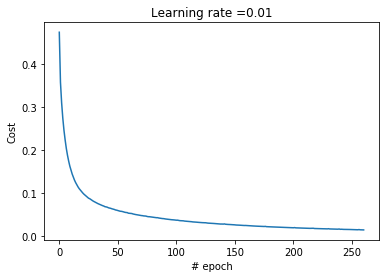

Accuracy of the model: 50.72%
C:\Python\Python36\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less_equal
  # This is added back by InteractiveShellApp.init_path()


In [24]:
# Check if the deep neural network is working
weight, bias = improved_deep_neural_network(nb_layer, neuron_quantity, activations, X, Y, learning_rate=0.01, epoch=2500, batch_size=128, beta1=0.9)

# Check if the prediction function works well
result = predict(X, weight, bias, nb_layer, activations)
accuracy = model_accuracy(result, Y)

# Tuning back the results from one-hot encoding to categorical values
# This will allow us to have a better comparison when comparing with the picture
Y = np.where(Y == 0, 2, 3)
result = np.where(result == 0, 2, 3)

print("Accuracy of the model: {0:.2f}%".format(accuracy*100))

Result was: [2]
Prediction was: [3]


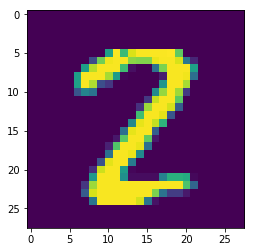

In [25]:
# Checking if the Neural Network learned properly with images
ind = 55
print("Result was: {0}".format(Y[ind]))
print("Prediction was: {0}".format(result[ind]))
plt.imshow(A["0"][ind].reshape(28,28))

In [26]:
# Checking where we are wrong
list_error = [i for i, x in enumerate(Y != result) if x]
error_rate = len(list_error) / len(Y) * 100
print("The model predicted wrong {0} times, or {1:.2f}% of the time".format(len(list_error), error_rate))

The model predicted wrong 5958 times, or 49.28% of the time


To Do:  
Implement possibility for different weight initialization  
Different Cost function for different purposes  
Different NN architecture (included CNN/RNN)  
Testing stability  
Explain "symmetry break" issue when setting parameters to 0  
Appendix with demonstration of each calculus